First, import required modules
---

In [1]:
import astropy.constants as const
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import matplotlib.patches as mpatch
from matplotlib.gridspec import GridSpec

import numpy as np
import sunpy.map

import pfsspy
from pfsspy import coords
from pfsspy import tracing

import helpers

In [2]:
from fig_params import figwidth, figdir, fontsize
import matplotlib
matplotlib.rcParams['figure.figsize'] = (2 * figwidth, figwidth)
matplotlib.rcParams['font.size'] = fontsize

Load GONG and AIA 193 maps
---

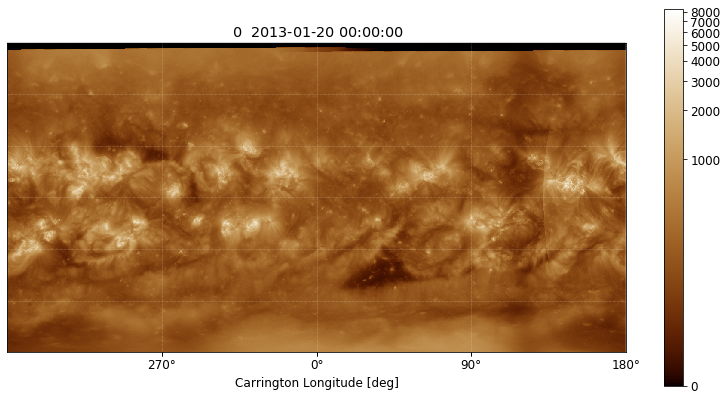

In [3]:
synoptic_map = helpers.get_B_map()

aia_disk = sunpy.map.Map('maps/AIA20130121_1206_0193.fits')
aia = sunpy.map.Map('maps/carrington_aia.fits')
aia.plot_settings = aia_disk.plot_settings
aia.meta['date-obs'] = synoptic_map.meta['date-obs']
aia.peek()

Calculate PFSS solution
---

In [4]:
nrho = 60
rss = 2.3

pfss_input = pfsspy.Input(synoptic_map, nrho, rss)
pfss_output = pfsspy.pfss(pfss_input)

Get pixel coordinates
---

In [5]:
nphi = 360
ntheta = 180

theta_1d = np.arcsin(np.arange(-1, 1, 2 / ntheta))
phi_1d = np.arange(-np.pi, np.pi, 2 * np.pi / nphi)
# Exclude the poles
theta_1d = theta_1d[1:-1]

# Create a meshgrid
lat, lon = np.meshgrid(theta_1d, phi_1d, indexing='ij')
lat, lon = lat * u.rad, lon * u.rad
r = const.R_sun

Construct seed point coordinates
---

In [6]:
seeds = SkyCoord(lon.ravel(), lat.ravel(), r, frame=pfss_output.coordinate_frame)
print(f'Number of seeds: {seeds.shape}')

Number of seeds: (64080,)


In [7]:
# Trace field lines
print('Tracing field lines...')
tracer = tracing.FortranTracer(1000, 0.01)
field_lines = tracer.trace(seeds, pfss_output)
print('Finished tracing field lines')

Tracing field lines...


/Users/dstansby/miniconda3/envs/pub-env/lib/python3.8/site-packages/pfsspy/tracing.py:156: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


Finished tracing field lines


In [8]:
pols = field_lines.polarities.reshape(lat.shape)

In [9]:
colors = [['tab:red'], ['tab:blue']]
levels = [[-1.5, -0.5], [0.5, 1.5]]

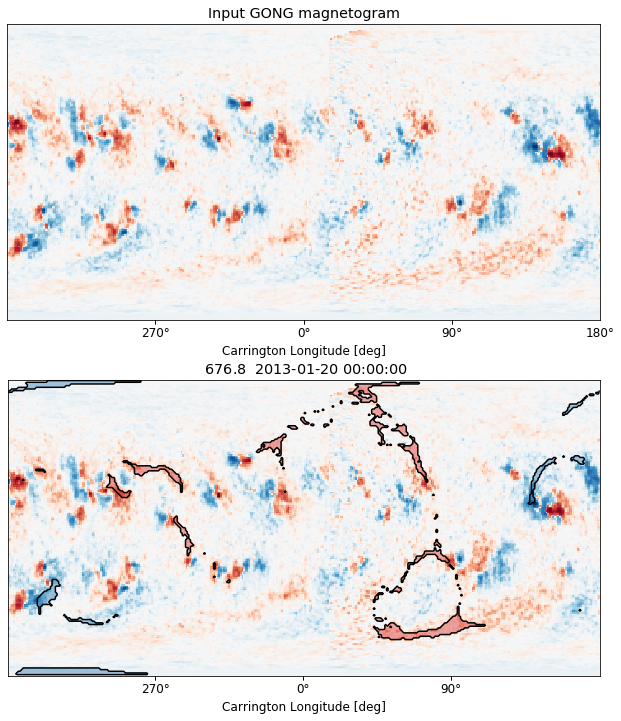

In [10]:
map_in = pfss_input.map
# Plot result
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(2, 1, 1, projection=map_in)
map_in.plot(ax, norm=mcolor.SymLogNorm(linthresh=10))
ax.set_title('Input GONG magnetogram')

ax = fig.add_subplot(2, 1, 2, projection=map_in)
map_in.plot(ax, norm=mcolor.SymLogNorm(linthresh=10))

for level, color in zip(levels, colors):
    ax.contourf(pols, levels=level, colors=color, alpha=0.4, extent=[0, 360, 0, 180])
    ax.contour(pols, levels=level, colors=['k'], extent=[0, 360, 0, 180], linestyles='solid')

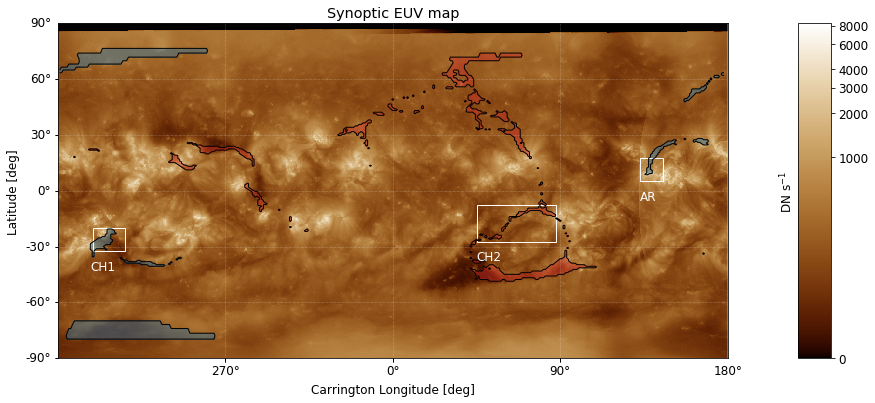

In [11]:
gs = GridSpec(1, 2, width_ratios=[20, 1])
fig = plt.figure()

ax = fig.add_subplot(gs[0, 0], projection=aia)
im = aia.plot()
# ax.set_xlim(0, 1440)

cmap = mcolor.ListedColormap(['tab:red', '#000000', 'tab:blue'])

X = ax.wcs.world_to_pixel(seeds)[0].reshape(lon.shape)[:, 1:-1]
Y = ax.wcs.world_to_pixel(seeds)[1].reshape(lat.shape)[:, 1:-1]
for level, color in zip(levels, colors):
    ax.contourf(X, Y, pols[:, 1:-1], levels=level, colors=color, alpha=0.4, extent=[0, 360, 0, 180])
    ax.contour(X, Y, pols[:, 1:-1], levels=level, colors=['k'], extent=[0, 360, 0, 180], linestyles='solid', linewidths=1)

ax.set_xlim(left=0.5)
ax.set_title('Synoptic EUV map')
# Region patches
ax.add_patch(mpatch.Rectangle((75, 230), 70, 50, edgecolor='white', linewidth=1, fill=False))
ax.text(70, 190, 'CH1', color='white')
ax.add_patch(mpatch.Rectangle((1250, 380), 50, 50, edgecolor='white', linewidth=1, fill=False))
ax.text(1250, 340, 'AR', color='white')
ax.add_patch(mpatch.Rectangle((900, 250), 170, 80, edgecolor='white', linewidth=1, fill=False))
ax.text(900, 210, 'CH2', color='white')


# Colourbar
ax = fig.add_subplot(gs[0, 1])
fig.colorbar(im, cax=ax, ticks=[0, 1000, 2000, 3000, 4000, 6000, 8000])
ax.set_ylabel('DN s$^{-1}$', labelpad=-90)

ax.set_aspect(10)

In [12]:
fig.savefig(f'aia_synop_open_closed.pdf', bbox_inches='tight')